In [16]:
# In this notebook, we will evaluate the results of the ellipse dataset training runs


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import json
from scipy.spatial.distance import directed_hausdorff

from sys import path
path.append('./../..')

base_output_dir = pathlib.Path('./../../output/lassen')
files = list(base_output_dir.glob('interfacial_ae_v5_*'))
len(files)


5

In [18]:
from src.interface_representation.interface_transformations import InterfaceRepresentationType

In [19]:
def read_loss_curve_from_file(outdir):
    loss_path = outdir / 'loss_history.json'
    with open(loss_path) as f:
        loss_curve = json.load(f)
    return loss_curve

def load_preds(outdir):
    pred_path = outdir / 'preds_75.npz'
    preds = np.load(pred_path)['preds']
    return preds

def load_gt(outdir):
    gt_path = outdir / 'gts_75.npz'
    gt = np.load(gt_path)['gts']
    return gt

def load_interface_type(filename):
    final_part = '_'.join(filename.stem.split('_')[-2:])
    
    str_to_type = {
        '00_datadirtanh': InterfaceRepresentationType.TANH,
        'datadirexact_sdf': InterfaceRepresentationType.SDF_EXACT,
        'datadirapprox_sdf': InterfaceRepresentationType.SDF_APPROX,
        'datadirtanh_sharp': InterfaceRepresentationType.TANH,
        'datadirtanh_smooth': InterfaceRepresentationType.TANH
    }
    
    return str_to_type[final_part]

def load_epsilon(filename):
    final_part = '_'.join(filename.stem.split('_')[-2:])
    
    str_to_epsilon = {
        '00_datadirtanh': 1/64,
        'datadirexact_sdf': None,
        'datadirapprox_sdf': None,
        'datadirtanh_sharp': 1/128,
        'datadirtanh_smooth': 1/32,
    }
    
    return str_to_epsilon[final_part]


def filename_to_plot_label(filename):
    final_part = '_'.join(filename.stem.split('_')[-2:])
    
    str_to_label = {
        '00_datadirtanh': 'Tanh 1/64',
        'datadirexact_sdf': 'Exact SDF',
        'datadirapprox_sdf': 'Approx. SDF',
        'datadirtanh_sharp': 'Tanh 1/128',
        'datadirtanh_smooth': 'Tanh 1/32'
    }
    
    return str_to_label[final_part]


def compute_phi_sharp_from_tanh(phi):
    return np.heaviside(phi - 0.5, 1)


def compute_phi_sharp_from_sdf(psi):
    return np.heaviside(-psi, 1)


def dice_coefficient(gt_patch, pred_patch, level: float = 0.5):
    """Returns the dice coefficient of foreground region, obtained by thresholding the images at level
    """
    gt_patch = gt_patch > level
    pred_patch = pred_patch > level
    intersection = np.sum(gt_patch * pred_patch)
    union = np.sum(gt_patch) + np.sum(pred_patch)
    return 2 * intersection / union


def hausdorff_distance(gt_patch, pred_patch, level: float = 0.5):
    """Returns the Hausdorff distance of the foreground region, obtained by thresholding the images at level

    Note:
        The distance is in units of voxels, assumes isotropic voxels

    Args:
        gt_patch: Ground truth patch
        pred_patch: Predicted patch
        level: Threshold level
        max_num_points: Maximum number of points to use in the distance calculation (for speed purposes)
    """
    gt_patch = gt_patch > level
    pred_patch = pred_patch > level

    gt_indices = np.argwhere(gt_patch) * 1 / 64
    pred_indices = np.argwhere(pred_patch) * 1 / 64

    if len(gt_indices) == 0 or len(pred_indices) == 0:
        return np.nan

    h_1 = directed_hausdorff(gt_indices, pred_indices)[0]
    h_2 = directed_hausdorff(pred_indices, gt_indices)[0]
    return max(h_1, h_2)


def get_phi_sharp_pred_and_gt(pred, gt, interface_type):
    if interface_type == InterfaceRepresentationType.TANH:
        pred = compute_phi_sharp_from_tanh(pred)
        gt = compute_phi_sharp_from_tanh(gt)
    elif interface_type == InterfaceRepresentationType.SDF_EXACT:
        pred = compute_phi_sharp_from_sdf(pred)
        gt = compute_phi_sharp_from_sdf(gt)
    elif interface_type == InterfaceRepresentationType.SDF_APPROX:
        pred = compute_phi_sharp_from_sdf(pred)
        gt = compute_phi_sharp_from_sdf(gt)
    else:
        raise ValueError('Unknown interface type')
    return pred, gt
    

In [20]:
files

[PosixPath('../../output/lassen/interfacial_ae_v5_run_02_datadirapprox_sdf'),
 PosixPath('../../output/lassen/interfacial_ae_v5_run_01_datadirexact_sdf'),
 PosixPath('../../output/lassen/interfacial_ae_v5_run_00_datadirtanh'),
 PosixPath('../../output/lassen/interfacial_ae_v5_run_03_datadirtanh_smooth'),
 PosixPath('../../output/lassen/interfacial_ae_v5_run_04_datadirtanh_sharp')]

In [ ]:
from tqdm import tqdm

plot_label_to_data = {}

for file in files:
    preds = load_preds(file)
    gts = load_gt(file)
    
    interfacetype = load_interface_type(file)
    plot_label = filename_to_plot_label(file)
    epsilon = load_epsilon(file)
    
    print(interfacetype, epsilon)
    
    assert len(preds) == len(gts)
    
    means = []
    dices = []
    hds = []
    
    for pred, gt in zip(preds, gts):
        pred, gt = get_phi_sharp_pred_and_gt(pred, gt, interfacetype)
        
        mse = np.mean((pred - gt)**2)
        means.append(mse)
        
        dice = dice_coefficient(gt, pred)
        dices.append(dice)
        
        hd = hausdorff_distance(gt, pred)
        hds.append(hd)
        
    plot_label_to_data[plot_label] = {
        'MSE': means,
        'Dice': dices,
        'Hausdorff': hds
    }
        
    

InterfaceRepresentationType.SDF_APPROX None


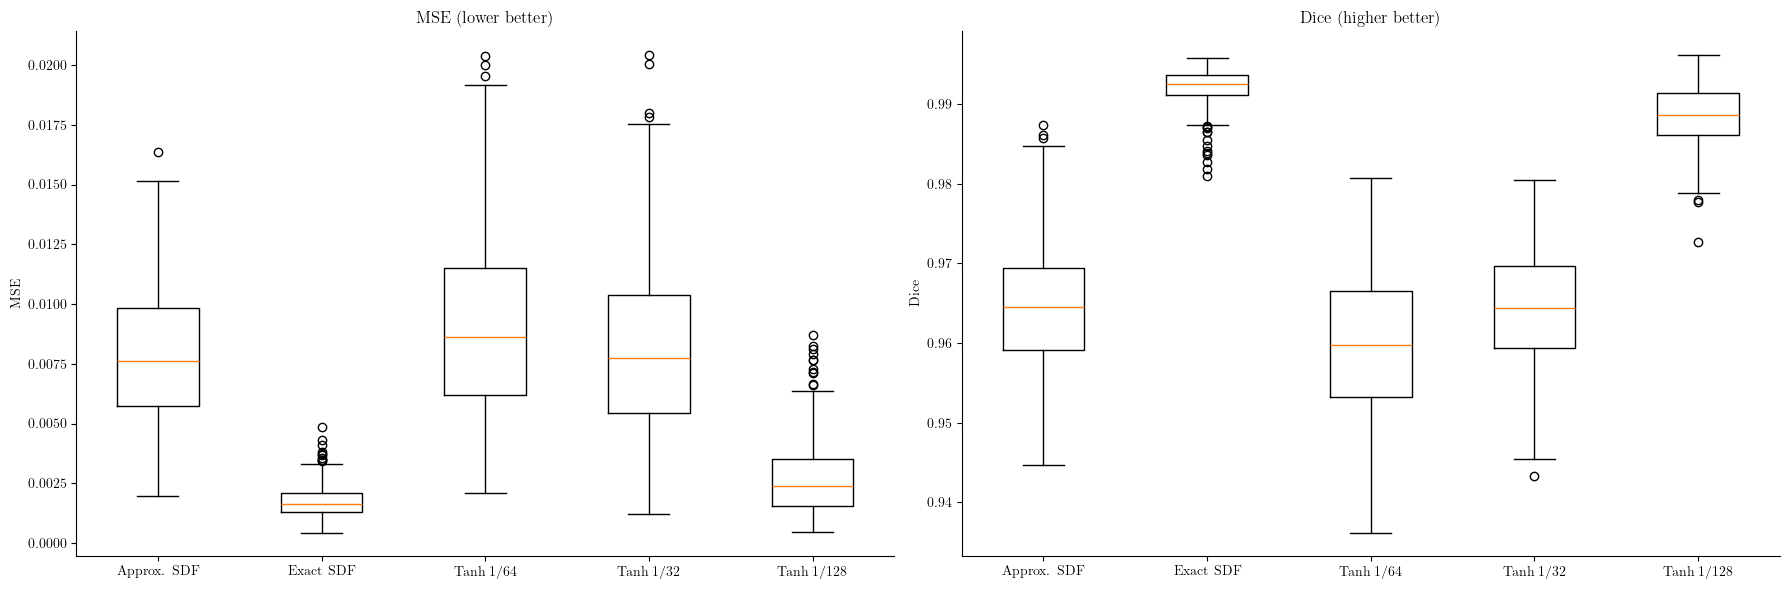

In [15]:
# For each metric, create a set of box plots with interface type on the x-axis
    
# For each metric, create a set of box plots with interface type on the x-axis

metrics = ['MSE', 'Dice', 'Hausdorff']  # Add 'Hausdorff' if needed
higher_or_lower = ['lower', 'higher', 'lower']
fig, axs = plt.subplots(1, len(metrics), figsize=(18, 6))

for i, metric in enumerate(metrics):
    data = [plot_label_to_data[label][metric] for label in plot_label_to_data]
    labels = list(plot_label_to_data.keys())
    axs[i].boxplot(data, tick_labels=labels)
    axs[i].set_title(f'{metric} ({higher_or_lower[i]} better)')
    axs[i].set_ylabel(metric)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()